In [56]:
## load the packages
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import folium
from folium import plugins
import datetime
import math
from sklearn import mixture
from sklearn.mixture import GaussianMixture
from sklearn.mixture import GMM


In [2]:
## Load in the aggregated bike data: 
## this is 2016-2018 bike data
totalTrips = pd.read_pickle('/Users/irena/Psych Bikes/Trips/bikedata_totalyears.pkl')

In [3]:
totalTrips.dtypes

trip_id                       int64
start_time           datetime64[ns]
end_time             datetime64[ns]
bikeid                        int64
tripduration                 object
from_station_id               int64
from_station_name            object
to_station_id                 int64
to_station_name              object
usertype                     object
gender                       object
birthyear                   float64
dtype: object

In [25]:
totalTrips['tripduration'] = totalTrips['tripduration'].replace(',', '')

In [4]:
totalTrips['tripduration'] = pd.to_numeric(totalTrips['tripduration'].astype('str'))


ValueError: Unable to parse string "2,904.0" at position 6740567

In [6]:
# create some variables that denote weekday vs. weekend, hour of day (0-24) 
totalTrips['is_weekend'] =totalTrips['start_time'].dt.dayofweek > 4
totalTrips['hour'] = totalTrips['start_time'].dt.hour
totalTrips['year']= totalTrips['start_time'].dt.year
totalTrips['week']= totalTrips['start_time'].dt.week

In [7]:
# also, add in morning and evening indicator variables 
totalTrips['is_morning'] = (totalTrips['hour'] > 5)& (totalTrips['hour'] <10)
totalTrips['is_evening'] = (totalTrips['hour'] > 15)& (totalTrips['hour'] <20)


In [32]:
totalTrips = totalTrips[totalTrips['is_weekend']==False]

In [19]:
# we are going to aggregate this data to the weekly level: 
totalTrips.head(10)

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,is_weekend,hour,year,week,is_morning,is_evening
0,13518905,2017-03-31 23:59:07,2017-04-01 00:13:24,5292,NaN,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0,False,23,2017,13,False,False
1,13518904,2017-03-31 23:56:25,2017-04-01 00:00:21,4408,NaN,199,Wabash Ave & Grand Ave,26,McClurg Ct & Illinois St,Subscriber,Male,1990.0,False,23,2017,13,False,False
2,13518903,2017-03-31 23:55:33,2017-04-01 00:01:21,696,NaN,520,Greenview Ave & Jarvis Ave,432,Clark St & Lunt Ave,Subscriber,Female,1979.0,False,23,2017,13,False,False
3,13518902,2017-03-31 23:54:46,2017-03-31 23:59:34,4915,NaN,110,Dearborn St & Erie St,142,McClurg Ct & Erie St,Subscriber,Male,1985.0,False,23,2017,13,False,False
4,13518901,2017-03-31 23:53:33,2017-04-01 00:00:28,4247,NaN,327,Sheffield Ave & Webster Ave,331,Halsted St & Blackhawk St (*),Subscriber,Female,1989.0,False,23,2017,13,False,False
5,13518900,2017-03-31 23:51:17,2017-03-31 23:55:19,3536,NaN,143,Sedgwick St & Webster Ave,289,Wells St & Concord Ln,Subscriber,Male,1988.0,False,23,2017,13,False,False
6,13518899,2017-03-31 23:51:16,2017-03-31 23:57:17,5111,NaN,81,Daley Center Plaza,41,Federal St & Polk St,Subscriber,Male,1987.0,False,23,2017,13,False,False
7,13518898,2017-03-31 23:50:26,2017-03-31 23:56:20,1579,NaN,56,Desplaines St & Kinzie St,77,Clinton St & Madison St,Subscriber,Male,1981.0,False,23,2017,13,False,False
8,13518897,2017-03-31 23:50:25,2017-03-31 23:55:24,3914,NaN,210,Ashland Ave & Division St,69,Damen Ave & Pierce Ave,Subscriber,Male,1992.0,False,23,2017,13,False,False
9,13518896,2017-03-31 23:49:58,2017-04-01 00:09:31,5455,NaN,117,Wilton Ave & Belmont Ave,29,Noble St & Milwaukee Ave,Subscriber,Male,1989.0,False,23,2017,13,False,False


In [33]:
## we will aggregate the data at the weekly level, 
# taking the count of trip_ids
departureData = totalTrips.groupby(['year','week','from_station_id','hour','is_morning','is_evening','usertype'], as_index=False)['trip_id'].count()
arrivalData = totalTrips.groupby(['year','week','to_station_id','hour','is_morning','is_evening','usertype'], as_index=False)['trip_id'].count()

#  and the average trip duration:
# meanData = totalTrips.groupby(['year','week','from_station_id','to_station_id','is_morning','is_evening','usertype', 'gender', 'is_weekend','birthyear'], as_index=False)['tripduration'].mean()

In [34]:
departureData.columns = ['year','week','id','hour','is_morning','is_evening','usertype','departure_count']
arrivalData.columns = ['year','week','id','hour','is_morning','is_evening','usertype', 'arrival_count']
arrivalData.head(10)

,year,week,id,hour,is_morning,is_evening,usertype,arrival_count
0,2016,1,2,13,False,False,Customer,1
1,2016,1,3,6,True,False,Customer,1
2,2016,1,3,7,True,False,Customer,1
3,2016,1,3,9,True,False,Subscriber,2
4,2016,1,3,10,False,False,Customer,2
5,2016,1,3,13,False,False,Subscriber,1
6,2016,1,4,7,True,False,Subscriber,1
7,2016,1,4,10,False,False,Customer,2
8,2016,1,4,12,False,False,Subscriber,2
9,2016,1,4,14,False,False,Customer,2


In [36]:
## merge the arrival and departure counts
totalData = pd.merge(arrivalData, departureData, on=['year','week','usertype','id','is_morning','is_evening','hour'], how='inner')

In [76]:
countData.shape

(4014630, 11)

In [53]:
from sklearn import datasets 

#Importing data from Iris dataset 

iris = datasets.load_iris()
X = iris.data[:,:2]
Y = iris.target
Y[:] = Y+1; 
Y.shape

(150,)

In [22]:
cleanup_variables = {"usertype":     {"Customer": 0, "Subscriber": 1, "Dependent": 2}}

In [37]:
totalData.replace(cleanup_variables, inplace=True)
totalData.head(10)

,year,week,id,hour,is_morning,is_evening,usertype,arrival_count,departure_count
0,2016,1,3,7,True,False,0,1,1
1,2016,1,4,10,False,False,0,2,1
2,2016,1,4,12,False,False,1,2,2
3,2016,1,5,7,True,False,1,1,3
4,2016,1,5,8,True,False,1,8,3
5,2016,1,5,11,False,False,1,3,1
6,2016,1,5,12,False,False,1,3,2
7,2016,1,5,13,False,False,1,3,2
8,2016,1,5,14,False,False,1,2,2
9,2016,1,5,15,False,False,1,1,2


In [64]:
# try with 2 subgroups
gmm =  GaussianMixture(n_components=2).fit(totalData)
# gmm.fit(totalData)
proba_lists = gmm.predict(totalData)

In [62]:
proba_lists

array([3, 1, 1, ..., 0, 1, 1])

In [65]:
# try with 3 subgroups
gmm =  GaussianMixture(n_components=3).fit(totalData)
# gmm.fit(totalData)
proba_lists2 = gmm.predict(totalData)

In [51]:
proba_lists2

array([2, 2, 0, ..., 0, 0, 0])

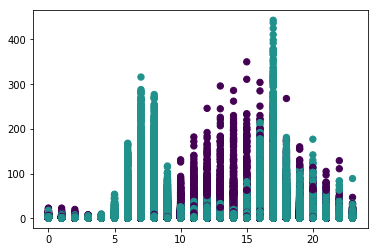

In [48]:
plt.scatter(totalData['hour'], totalData['departure_count'], c=totalData['usertype'], s=40);

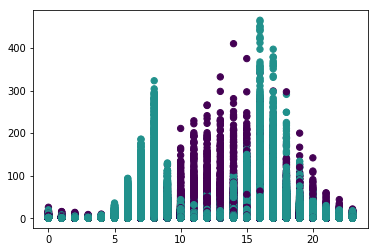

In [70]:
plt.scatter(totalData['hour'], totalData['arrival_count'], c=totalData['usertype'], s=40);

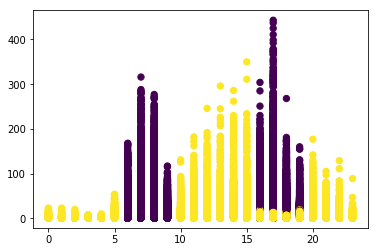

In [66]:
# plot 2 subgoups
plt.scatter(totalData['hour'], totalData['departure_count'], c=proba_lists, s=40);

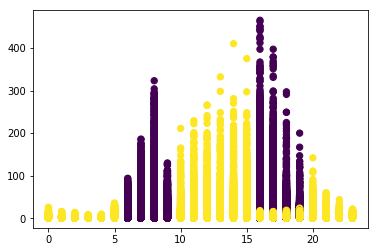

In [68]:
# plot 2 subgoups
plt.scatter(totalData['hour'], totalData['arrival_count'], c=proba_lists, s=40);

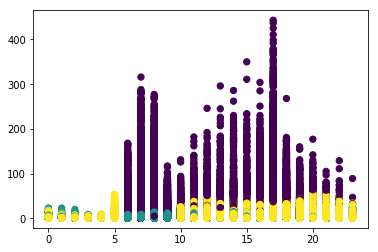

In [67]:
# plot 3 subgoups with departure count: 
plt.scatter(totalData['hour'], totalData['departure_count'], c=proba_lists2, s=40);

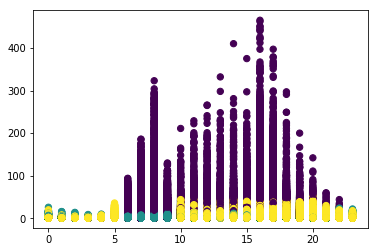

In [69]:
# plot 3 subgoups with arrival count: 
plt.scatter(totalData['hour'], totalData['arrival_count'], c=proba_lists2, s=40);

In [ ]:
plt.scatter(data['morning_ratio'], data['evening_ratio'])
plt.xlabel('Morning Ratio')
plt.ylabel('Evening Ratio')
plt.legend()
plt.show()
